In [ ]:
'''
pruebas del rendimiento de clasificación del encoder
'''

In [1]:
# libraries required

import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import polynomial_kernel, linear_kernel, sigmoid_kernel, rbf_kernel, laplacian_kernel
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!git clone "https://github.com/Carlosespicur/tfm_esteban"

Cloning into 'tfm_esteban'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 29.44 MiB | 8.17 MiB/s, done.
Updating files: 100% (7/7), done.
Filtering content: 100% (2/2), 148.03 MiB | 34.17 MiB/s, done.


In [3]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return torch.Tensor(polynomial_kernel(X = X, degree = degree, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "sigmoid":

        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return torch.Tensor(sigmoid_kernel(X = X, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return torch.Tensor(rbf_kernel(X = X, gamma = gamma))
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return torch.Tensor(laplacian_kernel(X = X, gamma = gamma))
        else:
            return None

    else:
        return None


def compute_metrics(preds, Y):
  accuracy = torch.sum(preds == Y)/len(Y)

  return accuracy.item()


In [4]:
class encoder(nn.Module):
    def __init__(self, input_size, latent_size):

        super().__init__()

        activation = nn.ReLU() # activation function
        self.encoder_layers = nn.ModuleList()

        # Encoder
        enc_layer_sizes = [input_size, 256, 128, latent_size]
        for k in range(len(enc_layer_sizes)-1):
          layer = nn.Linear(enc_layer_sizes[k], enc_layer_sizes[k+1])
          # weights initialization
          nn.init.xavier_uniform(layer.weight)
          layer.bias.data.fill_(0.01)

          self.encoder_layers.append(layer)
          self.encoder_layers.append(activation)

    def forward(self, x):
        for layer in self.encoder_layers:
          x = layer(x)

        return x

In [5]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
    super().__init__()

    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x







In [35]:
class encoder_SLMVP():

    def __init__(self, encoder, classificator, optimizer, kernel_parameters_X, kernel_parameters_Y = None ,lam = 1., label_indep = False, c = 1, mu = 1, ):

        self.lam = lam # regularization parameter
        self.c = c # constant used in cost function for the training process
        self.mu = mu # regularization parameter for leveling supervised trace error and search space requirements
        self.encoder = encoder
        self.classificator = classificator
        self.z = None # embeddings
        self.logits = None # input_logits
        self.optimizer = optimizer
        self.classification_loss = nn.CrossEntropyLoss()
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep

    def train(self, train_loader):

        self.encoder.train() # training mode: model parameters can be updated
        self.classificator.train()

        epoch_accuracies = [] # log of each minibatch accuracy
        epoch_class_losses = [] # log of each minibatch classification loss
        epoch_sup_losses = [] # log of each minibatch supervised loss
        epoch_restriction_losses = [] # log of each minibatch search space restriction loss
        epoch_losses = [] # log of each minibatch total loss

        for X, Y in tqdm(train_loader):

            self.optimizer.zero_grad() # clear gradients
            self.z = self.encoder(X) # embeddings
            self.logits = self.classificator(self.z)

            # compute minibatch accuracy
            preds = torch.argmax(self.logits, dim = 1)
            accuracy = torch.mean((preds == Y).float())



            # Compute similarity matrices
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
               K_Y = binary_distance(Y.unsqueeze(1), Y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(Y, **self.kernel_parameters_Y)
            #######################

            # l = K_X.shape[0]
            # j = np.ones(l)

            # K_X = K_X - (np.dot(np.dot(j,j.T),K_X))/l - (np.dot(K_X,np.dot(j,j.T)))/l + (np.dot((np.dot(j.T,np.dot(K_X,j))),np.dot(j,j.T)))/(np.power(l,2))

            # print(K_X, K_Y)
            # input()

            #######################
            K_XY = K_X * K_Y
            D = torch.diag(torch.sum(K_XY, dim = 1))

            # # OPCIÓN PÉRDIDA 1: maximizar la traza
            # sup_loss= -torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), K_XY), self.autoencoder.z)) # supervised trace error
            # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # We only want to consider matrices that satisfy sup_loss_restriction = 0
            # loss = (1-self.lam) * recon_loss + self.lam * (self.mu * sup_loss + (1-self.mu) * sup_loss_restriction)

            # # OPCIÓN PÉRDIDA 2: minimizar la traza --> Problema: los pesos tienden a hacerse cero
            # L = D - K_XY
            # sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
            # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # IGNORAR!!!!!!! No se utiliza para calcular la pérdida
            # loss = (1-self.lam) * recon_loss + self.lam * sup_loss

            # OPCIÓN PÉRDIDA 3: minimizar la traza manteniendo pesos grandes. Maximizamos tr(Z^T * Z) en paralelo para ello
            L = D - K_XY
            sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.z), L), self.z))
            sup_loss_restriction = (torch.trace(torch.matmul(torch.t(self.z), self.z)) - self.c)**2
            class_loss = self.classification_loss(self.logits, Y.long()) # classification loss
            loss = (1-self.lam) * 1000 * class_loss + self.lam * ((1 - self.mu) * sup_loss + self.mu * sup_loss_restriction)

            epoch_accuracies.append(accuracy)
            epoch_class_losses.append(class_loss)
            epoch_sup_losses.append(sup_loss)
            epoch_restriction_losses.append(sup_loss_restriction)
            epoch_losses.append(loss)


            loss.backward() # Compute gradients
            self.optimizer.step() # Update model parameters

        avg_accuracy = torch.mean(torch.tensor(epoch_accuracies))
        avg_class_loss = torch.mean(torch.tensor(epoch_class_losses))
        avg_sup_loss = torch.mean(torch.tensor(epoch_sup_losses))
        avg_restriction_loss = torch.mean(torch.tensor(epoch_restriction_losses))
        avg_loss = torch.mean(torch.tensor(epoch_losses))

        return avg_accuracy.item(), avg_class_loss.item(), avg_sup_loss.item(), avg_restriction_loss.item(), avg_loss.item()

    def test(self, data_loader):

      self.encoder.eval() # Evaluation mode: model parameters cannot be modified
      self.classificator.eval()

      test_accuracies = [] # log of minibatch accuracies
      test_class_losses = [] # log of minibatch classification losses
      test_sup_losses = [] # log of minibatch supervised losses
      test_restriction_losses = [] # log of each minibatch search space restriction loss
      test_losses = [] # log of minibatch losses

      for X, Y in data_loader:

        self.z = self.encoder(X)
        self.logits = self.classificator(self.z)

        # compute accuracy
        preds = torch.argmax(self.logits, dim = 1)
        accuracy = torch.mean((preds == Y).float())

        # Compute similarity matrices
        K_X = kernel(X, **self.kernel_parameters_X)
        if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
            K_Y = binary_distance(Y.unsqueeze(1), Y.unsqueeze(1))

        else:
            if self.kernel_parameters_Y == None:
                self.kernel_parameters_Y = self.kernel_parameters_X
            K_Y = kernel(Y, **self.kernel_parameters_Y)

        K_XY = K_X * K_Y
        D = torch.diag(torch.sum(K_XY, dim = 1))

        # # OPCIÓN PÉRDIDA 1: maximizar la traza
        # sup_loss= -torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), K_XY), self.autoencoder.z)) # supervised trace error
        # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # We only want to consider matrices that satisfy sup_loss_restriction = 0
        # loss = (1-self.lam) * recon_loss + self.lam * (self.mu * sup_loss + (1-self.mu) * sup_loss_restriction)

        # # OPCIÓN PÉRDIDA 2: minimizar la traza --> Problema: los pesos tienden a hacerse cero
        # L = D - K_XY
        # sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
        # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # IGNORAR!!!!!!!!!!!! No se utiliza para calcular la pérdida
        # loss = (1-self.lam) * recon_loss + self.lam * sup_loss

        # OPCIÓN PÉRDIDA 3: minimizar la traza manteniendo pesos grandes. Maximizamos tr(Z^T * Z) en paralelo para ello
        L = D - K_XY
        sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.z), L), self.z))
        sup_loss_restriction = (torch.trace(torch.matmul(torch.t(self.z), self.z)) - self.c)**2
        class_loss = self.classification_loss(self.logits, Y.long())
        loss = (1-self.lam) * 1000 * class_loss + self.lam * ((1 - self.mu) * sup_loss + self.mu * sup_loss_restriction)

        test_accuracies.append(accuracy)
        test_class_losses.append(class_loss)
        test_sup_losses.append(sup_loss)
        test_restriction_losses.append(sup_loss_restriction)
        test_losses.append(loss)

      avg_accuracy = torch.mean(torch.tensor(test_accuracies))
      avg_class_loss = torch.mean(torch.tensor(test_class_losses))
      avg_sup_loss = torch.mean(torch.tensor(test_sup_losses))
      avg_restriction_loss = torch.mean(torch.tensor(test_restriction_losses))
      avg_loss = torch.mean(torch.tensor(test_losses))

      return avg_accuracy.item(), avg_class_loss.item(), avg_sup_loss.item(), avg_restriction_loss.item(), avg_loss.item()

In [64]:
# Model hyperparameters

# loss = (1-self.lam) * 1000 * class_loss + self.lam * ((1 - self.mu) * sup_loss + self.mu * sup_loss_restriction)

lr = 0.001 # learning rate
batch_size = 64
epochs = 40
lam = 1e-5 # regularisation parameter for levelling reconstruction error and supervised trace error
mu = 0.3 # regularisation parameter for levelling supervised trace error and search space requirements
# c = None # constant that determines the ideal search space for encoder parameters. Defined in the next cell as dimensionality of the data
latent_size = 64 # latent space dimension
hidden_size = 16 # dimension of hidden layers in classification module
num_hidden_layers = 2 # number of hidden layers in classification module
# kernel function parameters for X_train / X_test

kernel_param_X = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1e-2,
    "coef": 0.5e2

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels


In [8]:
# fashion MNIST

# normalization dividing by 255

train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)
c = X_train.shape[1]
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

In [9]:
output_size = len(train_data["label"].unique())

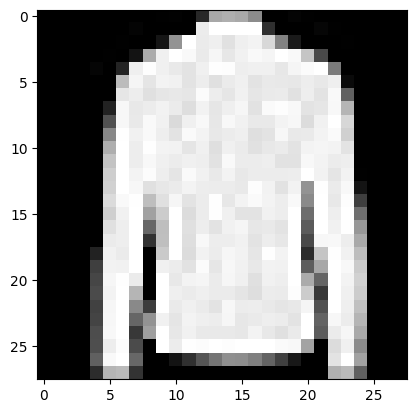

In [10]:
plt.imshow(X_train[7].reshape(28,28), cmap="gray")

In [65]:
# Model creation
input_size = X_train.shape[1]
encoder_base = encoder(input_size, latent_size)
classificator = MLP(latent_size, hidden_size, num_hidden_layers, output_size)

optimizer = torch.optim.Adam(list(encoder_base.parameters()) + list(classificator.parameters()), lr=lr, weight_decay=1e-5)
model = encoder_SLMVP(encoder = encoder_base, classificator = classificator, optimizer = optimizer, kernel_parameters_X = kernel_param_X, kernel_parameters_Y = kernel_param_Y, lam = lam, label_indep = label_indep, c = c, mu = mu)

<ipython-input-4-ccafa7955646>:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
<ipython-input-5-d553db3129f5>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
<ipython-input-5-d553db3129f5>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
<ipython-input-5-d553db3129f5>:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [66]:
# Model training

for epoch in range(epochs):

    print(f"*********** Epoch: {epoch + 1}/{epochs} *******************")
    train_avg_acc, train_avg_class_loss, train_avg_sup_loss, train_avg_sup_restriction_loss,train_avg_loss = model.train(train_loader)
    print(f"accuracy: {train_avg_acc}, class_loss: {train_avg_class_loss}, avg_sup_loss: {train_avg_sup_loss}, avg_sup_restrinction_loss: {train_avg_sup_restriction_loss} ,total_loss: {train_avg_loss}")
    val_avg_acc, val_avg_class_loss, val_avg_sup_loss, val_avg_sup_restriction_loss, val_avg_loss = model.test(val_loader)
    print(f"val_data --> accuracy: {val_avg_acc}, class_loss: {val_avg_class_loss}, avg_sup_loss: {val_avg_sup_loss}, avg_sup_restrinction_loss: {val_avg_sup_restriction_loss} ,total_loss: {val_avg_loss}")

*********** Epoch: 1/40 *******************


100%|██████████| 788/788 [00:10<00:00, 73.06it/s] 


accuracy: 0.4083716571331024, class_loss: 1.8407689332962036, avg_sup_loss: 4617901.5, avg_sup_restrinction_loss: 341778.15625 ,total_loss: 1874.10107421875
val_data --> accuracy: 0.4549005627632141, class_loss: 1.6972599029541016, avg_sup_loss: 1855249.5, avg_sup_restrinction_loss: 342759.6875 ,total_loss: 1711.2578125
*********** Epoch: 2/40 *******************


100%|██████████| 788/788 [00:09<00:00, 83.77it/s]


accuracy: 0.45062658190727234, class_loss: 1.6877238750457764, avg_sup_loss: 1779162.0, avg_sup_restrinction_loss: 330373.5 ,total_loss: 1701.15234375
val_data --> accuracy: 0.4458451569080353, class_loss: 1.6753579378128052, avg_sup_loss: 1483672.375, avg_sup_restrinction_loss: 345781.21875 ,total_loss: 1686.76416015625
*********** Epoch: 3/40 *******************


100%|██████████| 788/788 [00:09<00:00, 86.91it/s] 


accuracy: 0.44931790232658386, class_loss: 1.6749556064605713, avg_sup_loss: 1262155.0, avg_sup_restrinction_loss: 335359.59375 ,total_loss: 1684.780029296875
val_data --> accuracy: 0.4509943127632141, class_loss: 1.6716583967208862, avg_sup_loss: 1141131.0, avg_sup_restrinction_loss: 332834.96875 ,total_loss: 1680.628173828125
*********** Epoch: 4/40 *******************


100%|██████████| 788/788 [00:11<00:00, 71.43it/s]


accuracy: 0.4504084587097168, class_loss: 1.6692206859588623, avg_sup_loss: 931419.1875, avg_sup_restrinction_loss: 327017.0625 ,total_loss: 1676.705078125
val_data --> accuracy: 0.4509943127632141, class_loss: 1.6683878898620605, avg_sup_loss: 799925.25, avg_sup_restrinction_loss: 337290.5 ,total_loss: 1674.9825439453125
*********** Epoch: 5/40 *******************


100%|██████████| 788/788 [00:09<00:00, 84.22it/s] 


accuracy: 0.4513404071331024, class_loss: 1.667477011680603, avg_sup_loss: 781322.75, avg_sup_restrinction_loss: 314820.65625 ,total_loss: 1673.8740234375
val_data --> accuracy: 0.44992896914482117, class_loss: 1.666469931602478, avg_sup_loss: 719113.5625, avg_sup_restrinction_loss: 316806.5 ,total_loss: 1672.4375
*********** Epoch: 6/40 *******************


100%|██████████| 788/788 [00:09<00:00, 80.26it/s] 


accuracy: 0.4531448185443878, class_loss: 1.6658543348312378, avg_sup_loss: 680313.5625, avg_sup_restrinction_loss: 299933.375 ,total_loss: 1671.4998779296875
val_data --> accuracy: 0.47549715638160706, class_loss: 1.669193983078003, avg_sup_loss: 804941.8125, avg_sup_restrinction_loss: 290226.25 ,total_loss: 1675.6824951171875
*********** Epoch: 7/40 *******************


100%|██████████| 788/788 [00:08<00:00, 93.59it/s] 


accuracy: 0.4523318409919739, class_loss: 1.6654770374298096, avg_sup_loss: 621765.1875, avg_sup_restrinction_loss: 279619.09375 ,total_loss: 1670.6514892578125
val_data --> accuracy: 0.4469105005264282, class_loss: 1.6645808219909668, avg_sup_loss: 731752.375, avg_sup_restrinction_loss: 291314.09375 ,total_loss: 1670.5601806640625
*********** Epoch: 8/40 *******************


100%|██████████| 788/788 [00:09<00:00, 82.14it/s]


accuracy: 0.4549492299556732, class_loss: 1.6642041206359863, avg_sup_loss: 548894.1875, avg_sup_restrinction_loss: 266315.5 ,total_loss: 1668.8287353515625
val_data --> accuracy: 0.4527698755264282, class_loss: 1.671615481376648, avg_sup_loss: 695209.625, avg_sup_restrinction_loss: 250407.1875 ,total_loss: 1677.2164306640625
*********** Epoch: 9/40 *******************


100%|██████████| 788/788 [00:09<00:00, 79.60it/s] 


accuracy: 0.4592718780040741, class_loss: 1.6633775234222412, avg_sup_loss: 519048.78125, avg_sup_restrinction_loss: 225965.140625 ,total_loss: 1667.6719970703125
val_data --> accuracy: 0.4554332494735718, class_loss: 1.6652203798294067, avg_sup_loss: 651160.0625, avg_sup_restrinction_loss: 206739.609375 ,total_loss: 1670.382080078125
*********** Epoch: 10/40 *******************


100%|██████████| 788/788 [00:10<00:00, 73.97it/s]


accuracy: 0.4666283428668976, class_loss: 1.6630057096481323, avg_sup_loss: 488135.4375, avg_sup_restrinction_loss: 197349.3125 ,total_loss: 1666.997802734375
val_data --> accuracy: 0.4547230005264282, class_loss: 1.6645252704620361, avg_sup_loss: 495465.3125, avg_sup_restrinction_loss: 188692.796875 ,total_loss: 1668.54296875
*********** Epoch: 11/40 *******************


100%|██████████| 788/788 [00:09<00:00, 84.01it/s] 


accuracy: 0.4737071692943573, class_loss: 1.664355754852295, avg_sup_loss: 476552.1875, avg_sup_restrinction_loss: 177551.921875 ,total_loss: 1668.207763671875
val_data --> accuracy: 0.48313209414482117, class_loss: 1.6677302122116089, avg_sup_loss: 466941.78125, avg_sup_restrinction_loss: 160112.390625 ,total_loss: 1671.4625244140625
*********** Epoch: 12/40 *******************


100%|██████████| 788/788 [00:10<00:00, 77.21it/s] 


accuracy: 0.47981441020965576, class_loss: 1.661250352859497, avg_sup_loss: 436150.59375, avg_sup_restrinction_loss: 143539.046875 ,total_loss: 1664.717529296875
val_data --> accuracy: 0.4770951569080353, class_loss: 1.6650569438934326, avg_sup_loss: 453930.40625, avg_sup_restrinction_loss: 123162.2421875 ,total_loss: 1668.58740234375
*********** Epoch: 13/40 *******************


100%|██████████| 788/788 [00:08<00:00, 89.95it/s] 


accuracy: 0.48205503821372986, class_loss: 1.6601227521896362, avg_sup_loss: 424694.90625, avg_sup_restrinction_loss: 104036.984375 ,total_loss: 1663.3909912109375
val_data --> accuracy: 0.4827769994735718, class_loss: 1.666860580444336, avg_sup_loss: 467374.46875, avg_sup_restrinction_loss: 96401.9296875 ,total_loss: 1670.4046630859375
*********** Epoch: 14/40 *******************


100%|██████████| 788/788 [00:06<00:00, 113.35it/s]


accuracy: 0.49032360315322876, class_loss: 1.6594581604003906, avg_sup_loss: 466883.625, avg_sup_restrinction_loss: 78047.7890625 ,total_loss: 1662.9439697265625
val_data --> accuracy: 0.4829545319080353, class_loss: 1.6647051572799683, avg_sup_loss: 557310.25, avg_sup_restrinction_loss: 67798.359375 ,total_loss: 1668.79296875
*********** Epoch: 15/40 *******************


100%|██████████| 788/788 [00:11<00:00, 70.44it/s]


accuracy: 0.4937341511249542, class_loss: 1.6584560871124268, avg_sup_loss: 460322.53125, avg_sup_restrinction_loss: 59805.03515625 ,total_loss: 1661.8411865234375
val_data --> accuracy: 0.4975142180919647, class_loss: 1.658364176750183, avg_sup_loss: 434587.625, avg_sup_restrinction_loss: 58852.61328125 ,total_loss: 1661.56640625
*********** Epoch: 16/40 *******************


100%|██████████| 788/788 [00:10<00:00, 73.80it/s]


accuracy: 0.4956773519515991, class_loss: 1.657884955406189, avg_sup_loss: 477610.9375, avg_sup_restrinction_loss: 53198.59765625 ,total_loss: 1661.371337890625
val_data --> accuracy: 0.4840198755264282, class_loss: 1.6638381481170654, avg_sup_loss: 463569.8125, avg_sup_restrinction_loss: 49850.28515625 ,total_loss: 1667.2159423828125
*********** Epoch: 17/40 *******************


100%|██████████| 788/788 [00:09<00:00, 79.15it/s]


accuracy: 0.4908193349838257, class_loss: 1.6575019359588623, avg_sup_loss: 410880.4375, avg_sup_restrinction_loss: 45494.69140625 ,total_loss: 1660.498046875
val_data --> accuracy: 0.4866832494735718, class_loss: 1.662642240524292, avg_sup_loss: 431313.59375, avg_sup_restrinction_loss: 43515.76953125 ,total_loss: 1665.775390625
*********** Epoch: 18/40 *******************


100%|██████████| 788/788 [00:08<00:00, 94.84it/s]


accuracy: 0.49058136343955994, class_loss: 1.6548198461532593, avg_sup_loss: 364247.875, avg_sup_restrinction_loss: 36522.5078125 ,total_loss: 1657.4625244140625
val_data --> accuracy: 0.4827769994735718, class_loss: 1.6598515510559082, avg_sup_loss: 400730.21875, avg_sup_restrinction_loss: 38930.9375 ,total_loss: 1662.757080078125
*********** Epoch: 19/40 *******************


100%|██████████| 788/788 [00:10<00:00, 76.82it/s] 


accuracy: 0.49524110555648804, class_loss: 1.65663480758667, avg_sup_loss: 391903.75, avg_sup_restrinction_loss: 32844.8828125 ,total_loss: 1659.4600830078125
val_data --> accuracy: 0.48916903138160706, class_loss: 1.6635464429855347, avg_sup_loss: 429459.625, avg_sup_restrinction_loss: 34847.140625 ,total_loss: 1666.640625
*********** Epoch: 20/40 *******************


100%|██████████| 788/788 [00:10<00:00, 75.66it/s]


accuracy: 0.5002180933952332, class_loss: 1.656175136566162, avg_sup_loss: 403101.0625, avg_sup_restrinction_loss: 33545.7578125 ,total_loss: 1659.0810546875
val_data --> accuracy: 0.48703834414482117, class_loss: 1.6565943956375122, avg_sup_loss: 348276.09375, avg_sup_restrinction_loss: 28371.244140625 ,total_loss: 1659.10107421875
*********** Epoch: 21/40 *******************


100%|██████████| 788/788 [00:07<00:00, 112.38it/s]


accuracy: 0.5043821334838867, class_loss: 1.652218222618103, avg_sup_loss: 402401.8125, avg_sup_restrinction_loss: 31477.857421875 ,total_loss: 1655.1129150390625
val_data --> accuracy: 0.49715909361839294, class_loss: 1.6555424928665161, avg_sup_loss: 484434.46875, avg_sup_restrinction_loss: 26971.662109375 ,total_loss: 1658.9979248046875
*********** Epoch: 22/40 *******************


100%|██████████| 788/788 [00:11<00:00, 67.07it/s] 


accuracy: 0.5103108882904053, class_loss: 1.652820110321045, avg_sup_loss: 459357.65625, avg_sup_restrinction_loss: 35274.96484375 ,total_loss: 1656.125
val_data --> accuracy: 0.5090553760528564, class_loss: 1.6507683992385864, avg_sup_loss: 596302.25, avg_sup_restrinction_loss: 42701.21484375 ,total_loss: 1655.05419921875
*********** Epoch: 23/40 *******************


100%|██████████| 788/788 [00:11<00:00, 68.72it/s]


accuracy: 0.5053735971450806, class_loss: 1.6484782695770264, avg_sup_loss: 514762.53125, avg_sup_restrinction_loss: 41083.546875 ,total_loss: 1652.188232421875
val_data --> accuracy: 0.5600141882896423, class_loss: 1.6507071256637573, avg_sup_loss: 734283.6875, avg_sup_restrinction_loss: 34044.68359375 ,total_loss: 1655.932861328125
*********** Epoch: 24/40 *******************


100%|██████████| 788/788 [00:11<00:00, 67.37it/s]


accuracy: 0.5042433142662048, class_loss: 1.6474459171295166, avg_sup_loss: 451465.21875, avg_sup_restrinction_loss: 33910.87890625 ,total_loss: 1650.6912841796875
val_data --> accuracy: 0.49733665585517883, class_loss: 1.6541520357131958, avg_sup_loss: 640923.125, avg_sup_restrinction_loss: 27035.11328125 ,total_loss: 1658.7030029296875
*********** Epoch: 25/40 *******************


100%|██████████| 788/788 [00:14<00:00, 55.09it/s]


accuracy: 0.5069797039031982, class_loss: 1.646275520324707, avg_sup_loss: 466607.40625, avg_sup_restrinction_loss: 27148.8203125 ,total_loss: 1649.6070556640625
val_data --> accuracy: 0.4959161877632141, class_loss: 1.6561775207519531, avg_sup_loss: 620072.5, avg_sup_restrinction_loss: 28148.017578125 ,total_loss: 1660.5859375
*********** Epoch: 26/40 *******************


100%|██████████| 788/788 [00:14<00:00, 54.37it/s]


accuracy: 0.5128291845321655, class_loss: 1.6448618173599243, avg_sup_loss: 442283.6875, avg_sup_restrinction_loss: 27523.361328125 ,total_loss: 1648.0238037109375
val_data --> accuracy: 0.5090553760528564, class_loss: 1.6482055187225342, avg_sup_loss: 432488.90625, avg_sup_restrinction_loss: 35622.96484375 ,total_loss: 1651.3231201171875
*********** Epoch: 27/40 *******************


100%|██████████| 788/788 [00:16<00:00, 46.77it/s]


accuracy: 0.5083677172660828, class_loss: 1.6454359292984009, avg_sup_loss: 451417.5, avg_sup_restrinction_loss: 30773.0234375 ,total_loss: 1648.6719970703125
val_data --> accuracy: 0.5422585010528564, class_loss: 1.6529399156570435, avg_sup_loss: 490843.46875, avg_sup_restrinction_loss: 30762.267578125 ,total_loss: 1656.4512939453125
*********** Epoch: 28/40 *******************


100%|██████████| 788/788 [00:18<00:00, 43.30it/s]


accuracy: 0.5113816857337952, class_loss: 1.643741488456726, avg_sup_loss: 426723.5, avg_sup_restrinction_loss: 31344.9296875 ,total_loss: 1646.80615234375
val_data --> accuracy: 0.4927201569080353, class_loss: 1.649709701538086, avg_sup_loss: 461381.375, avg_sup_restrinction_loss: 28567.88671875 ,total_loss: 1653.0086669921875
*********** Epoch: 29/40 *******************


100%|██████████| 788/788 [00:17<00:00, 44.42it/s]


accuracy: 0.5114213228225708, class_loss: 1.644039273262024, avg_sup_loss: 423570.4375, avg_sup_restrinction_loss: 28823.5234375 ,total_loss: 1647.07421875
val_data --> accuracy: 0.5166903138160706, class_loss: 1.645792007446289, avg_sup_loss: 450428.625, avg_sup_restrinction_loss: 27091.232421875 ,total_loss: 1649.009765625
*********** Epoch: 30/40 *******************


100%|██████████| 788/788 [00:22<00:00, 35.70it/s]


accuracy: 0.5117782354354858, class_loss: 1.6434998512268066, avg_sup_loss: 476445.65625, avg_sup_restrinction_loss: 26778.802734375 ,total_loss: 1646.89892578125
val_data --> accuracy: 0.5163352489471436, class_loss: 1.6470128297805786, avg_sup_loss: 572013.375, avg_sup_restrinction_loss: 24991.716796875 ,total_loss: 1651.07568359375
*********** Epoch: 31/40 *******************


100%|██████████| 788/788 [00:27<00:00, 28.88it/s]


accuracy: 0.5089030861854553, class_loss: 1.643149733543396, avg_sup_loss: 481729.46875, avg_sup_restrinction_loss: 29680.15234375 ,total_loss: 1646.5943603515625
val_data --> accuracy: 0.5154474377632141, class_loss: 1.6494532823562622, avg_sup_loss: 443641.625, avg_sup_restrinction_loss: 36067.10546875 ,total_loss: 1652.6505126953125
*********** Epoch: 32/40 *******************


100%|██████████| 788/788 [00:27<00:00, 28.81it/s]


accuracy: 0.5158034563064575, class_loss: 1.6412478685379028, avg_sup_loss: 424349.5625, avg_sup_restrinction_loss: 27305.498046875 ,total_loss: 1644.283935546875
val_data --> accuracy: 0.4886363744735718, class_loss: 1.6475695371627808, avg_sup_loss: 370171.78125, avg_sup_restrinction_loss: 30793.693359375 ,total_loss: 1650.23681640625
*********** Epoch: 33/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.62it/s]


accuracy: 0.5197295546531677, class_loss: 1.6416258811950684, avg_sup_loss: 427788.65625, avg_sup_restrinction_loss: 29924.466796875 ,total_loss: 1644.69384765625
val_data --> accuracy: 0.548828125, class_loss: 1.6451866626739502, avg_sup_loss: 518136.53125, avg_sup_restrinction_loss: 36874.421875 ,total_loss: 1648.90771484375
*********** Epoch: 34/40 *******************


100%|██████████| 788/788 [00:36<00:00, 21.85it/s]


accuracy: 0.5174294114112854, class_loss: 1.6418094635009766, avg_sup_loss: 423934.75, avg_sup_restrinction_loss: 29313.802734375 ,total_loss: 1644.8486328125
val_data --> accuracy: 0.5140269994735718, class_loss: 1.6526679992675781, avg_sup_loss: 477425.6875, avg_sup_restrinction_loss: 28825.392578125 ,total_loss: 1656.0797119140625
*********** Epoch: 35/40 *******************


100%|██████████| 788/788 [00:35<00:00, 22.31it/s]


accuracy: 0.5153870582580566, class_loss: 1.6414240598678589, avg_sup_loss: 437729.40625, avg_sup_restrinction_loss: 25345.994140625 ,total_loss: 1644.5477294921875
val_data --> accuracy: 0.5122514367103577, class_loss: 1.6435338258743286, avg_sup_loss: 469128.1875, avg_sup_restrinction_loss: 21937.86328125 ,total_loss: 1646.8670654296875
*********** Epoch: 36/40 *******************


100%|██████████| 788/788 [00:41<00:00, 19.05it/s]


accuracy: 0.5231004357337952, class_loss: 1.6417131423950195, avg_sup_loss: 440514.15625, avg_sup_restrinction_loss: 29011.8828125 ,total_loss: 1644.8671875
val_data --> accuracy: 0.5346235632896423, class_loss: 1.6440304517745972, avg_sup_loss: 530237.1875, avg_sup_restrinction_loss: 36935.48828125 ,total_loss: 1647.836669921875
*********** Epoch: 37/40 *******************


100%|██████████| 788/788 [00:37<00:00, 21.02it/s]


accuracy: 0.5284938216209412, class_loss: 1.6422404050827026, avg_sup_loss: 432079.09375, avg_sup_restrinction_loss: 33621.19140625 ,total_loss: 1645.3492431640625
val_data --> accuracy: 0.5649858117103577, class_loss: 1.6480598449707031, avg_sup_loss: 439530.46875, avg_sup_restrinction_loss: 32098.375 ,total_loss: 1651.2164306640625
*********** Epoch: 38/40 *******************


100%|██████████| 788/788 [00:41<00:00, 18.89it/s]


accuracy: 0.5203441977500916, class_loss: 1.6396511793136597, avg_sup_loss: 411231.15625, avg_sup_restrinction_loss: 30095.955078125 ,total_loss: 1642.6036376953125
val_data --> accuracy: 0.5470525622367859, class_loss: 1.6466456651687622, avg_sup_loss: 990918.5625, avg_sup_restrinction_loss: 21552.1796875 ,total_loss: 1653.63037109375
*********** Epoch: 39/40 *******************


100%|██████████| 788/788 [00:35<00:00, 22.32it/s]


accuracy: 0.5257574319839478, class_loss: 1.6412421464920044, avg_sup_loss: 440661.65625, avg_sup_restrinction_loss: 27346.96484375 ,total_loss: 1644.3924560546875
val_data --> accuracy: 0.544921875, class_loss: 1.6440544128417969, avg_sup_loss: 484548.78125, avg_sup_restrinction_loss: 25521.658203125 ,total_loss: 1647.50634765625
*********** Epoch: 40/40 *******************


100%|██████████| 788/788 [00:37<00:00, 21.15it/s]


accuracy: 0.5184406638145447, class_loss: 1.6397147178649902, avg_sup_loss: 468550.625, avg_sup_restrinction_loss: 25612.193359375 ,total_loss: 1643.0550537109375
val_data --> accuracy: 0.5259233117103577, class_loss: 1.6422767639160156, avg_sup_loss: 484248.625, avg_sup_restrinction_loss: 25004.0234375 ,total_loss: 1645.72509765625


In [51]:
# model testing

test_avg_acc, test_avg_class_loss, test_avg_sup_loss, test_avg_sup_restriction_loss, test_avg_loss = model.train(test_loader)
print(f"accuracy: {test_avg_acc}, class_loss: {test_avg_class_loss:.3f}, avg_sup_loss: {test_avg_sup_loss:.3f}, avg_sup_restrinction_loss: {test_avg_sup_restriction_loss:.3f}, total_loss: {test_avg_loss:.3f}")

100%|██████████| 219/219 [00:05<00:00, 42.93it/s]

accuracy: 0.8636558055877686, class_loss: 1.548, avg_sup_loss: 595062016.000, avg_sup_restrinction_loss: 8595478.000, total_loss: 1549.893
